# START HERE for preliminary EERIE IFS-AMIP runs at low-resolution (tco399, ~28 km)

## Introduction

In [1]:
%matplotlib auto  # For the app to work well we need to disable inline plotting
import xarray as xr
import pandas as pd
import numpy as np
import intake

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import seaborn as sns
import scipy.stats as stats
from datetime import datetime

from dask.diagnostics import ProgressBar
xr.set_options(keep_attrs=True)


Using matplotlib backend: <object object at 0x7fffe411a570>


In [2]:
def ifs_to_latlon(ds):
    '''
    Uses the latitude-longitude information encoded in the regular grid IFS output to reconstructed the regular grid
    '''
    return ds.rename({'value':'latlon'}).set_index(latlon=("lat","lon")).unstack("latlon")


def ifs_fix_time_for_monthly_data(ds):
    '''
    Monthly mean data has the time axis encoded incorrectly.
    This function shifts it back by one day
    '''
    return ds.assign_coords(time=ds['time']- pd.Timedelta('1D'))


Some useful functions to compute the statistical significante. Iuliia used wilcoxon whis is 
probably more robust, but it is slow, so I defined also a function using a T-test to get going in the hackaton.

In [ ]:

def wilcoxon_gufunc(x,y):
    s,p = stats.wilcoxon(x, y, zero_method="zsplit") 
    return p


def wilcoxon_xr(x, y):
    return xr.apply_ufunc(
        wilcoxon_gufunc, # first the function
        x,  # now arguments in the order expected by the function
        y,
        input_core_dims=[["time"],["time"]],  # list with one entry per arg
        output_core_dims=[[]],
        #exclude_dims=set(("lat",)),
        dask="parallelized",
        output_dtypes=[float],
        vectorize=True,  # loop over non-core dims
    )

def dttest_gufunc(x,y):
    s,p = stats.ttest_rel(x, y) 
    return p


def dttest_xr(x, y):
    return xr.apply_ufunc(
        dttest_gufunc, # first the function
        x,  # now arguments in the order expected by the function
        y,
        input_core_dims=[["time"],["time"]],  # list with one entry per arg
        output_core_dims=[[]],
        #exclude_dims=set(("lat",)),
        dask="parallelized",
        output_dtypes=[float],
        vectorize=True,  # loop over non-core dims
    )

## Open and inspect the catalogue

In [3]:
cat = intake.open_catalog('https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml')\
                          ['dkrz']['disk']['model-output']['ifs-amip']

In [4]:
list(cat)

['amip-hist-obs.atmos.gr025',
 'amip-hist-obs-lr30.atmos.gr025',
 'amip-hist-obs-c-lr30-a-0.atmos.gr025',
 'amip-hist-obs-c-lr30-a-lr30.atmos.gr025',
 'amip-ng-obs.atmos.gr025',
 'amip-ng-obs-lr30.atmos.gr025',
 'amip-hist-esav3.atmos.gr025',
 'amip-hist-esav3-c-0-a-lr30.atmos.gr025']

In [5]:
list(cat['amip-hist-obs.atmos.gr025'])

['2D_24h_0.25deg',
 '2D_6h_0.25deg',
 '2D_6h_native',
 '2D_const_0.25deg',
 '2D_monthly_0.25deg',
 '3D_24h_0.25deg',
 '3D_6h_0.25deg',
 '3D_monthly_0.25deg']

In [6]:
list(cat['amip-hist-obs-lr30.atmos.gr025'])

['2D_24h_0.25deg',
 '2D_6h_0.25deg',
 '2D_6h_native',
 '2D_const_0.25deg',
 '2D_monthly_0.25deg',
 '3D_24h_0.25deg',
 '3D_6h_0.25deg',
 '3D_monthly_0.25deg']

In [7]:
list(cat['amip-hist-obs-c-lr30-a-0.atmos.gr025'])

['2D_24h_0.25deg',
 '2D_6h_0.25deg',
 '2D_6h_native',
 '2D_monthly_0.25deg',
 '3D_24h_0.25deg',
 '3D_6h_0.25deg',
 '3D_monthly_0.25deg']

In [8]:
list(cat['amip-hist-obs-c-lr30-a-lr30.atmos.gr025'])

['2D_24h_0.25deg',
 '2D_6h_0.25deg',
 '2D_6h_native',
 '2D_monthly_0.25deg',
 '3D_24h_0.25deg',
 '3D_6h_0.25deg',
 '3D_monthly_0.25deg']

In [9]:
list(cat['amip-hist-obs-c-lr30-a-lr30.atmos.gr025'])

['2D_24h_0.25deg',
 '2D_6h_0.25deg',
 '2D_6h_native',
 '2D_monthly_0.25deg',
 '3D_24h_0.25deg',
 '3D_6h_0.25deg',
 '3D_monthly_0.25deg']

In [10]:
list(cat['amip-ng-obs-lr30.atmos.gr025'])

['2D_6h_0.25deg', '2D_6h_0.25deg_lightning', '3D_24h_0.25deg']

Here we define the app using the panel library (https://panel.holoviz.org/). This is a toy app that is slow and has several limitations, but it is still useful to analyse the data in an easier way than having to define each figure in a sepparate way.

/tmp/ipykernel_605811/4128709923.py:140: PanelDeprecationWarning: 'panel.Pane' is deprecated and will be removed in version 1.0, use 'panel.panel' instead.
  main = pn.Pane(interactive_plot)
/tmp/ipykernel_605811/4128709923.py:103: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
  ax.background_patch.set_facecolor("lightgrey")


Column
    [0] GridBox(ncols=4)
        [0] WidgetBox
            [0] Select(name='simulation', options=['amip-hist-obs.atmos.gr02...], value='amip-hist-obs.atmos.gr025...)
            [1] Markdown(str)
        [1] WidgetBox
            [0] Select(name='compare_with', options=['amip-hist-obs.atmos.gr02...], value='None')
            [1] Markdown(str)
        [2] WidgetBox
            [0] Select(name='variable', options=['10si', '10u', ...], value='sst')
            [1] Markdown(str)
        [3] WidgetBox
            [0] Select(name='season', options=['Annual', 'DJF', ...], value='Annual')
            [1] Markdown(str)
        [4] WidgetBox
            [0] ArrayInput(max_array_size=4, name='area [minlon, ...)
            [1] Markdown(str)
        [5] WidgetBox
            [0] Select(name='colormap', options=['default', 'nipy_spectral...], value='default')
            [1] Markdown(str)
        [6] WidgetBox
            [0] FloatInput(name='vmin')
            [1] Markdown(str)
        [7] WidgetBox
            [0] FloatInput(name='vmax')
            [1] Markdown(str)
    [1] ParamFunction(function, _pane=Matplotlib)
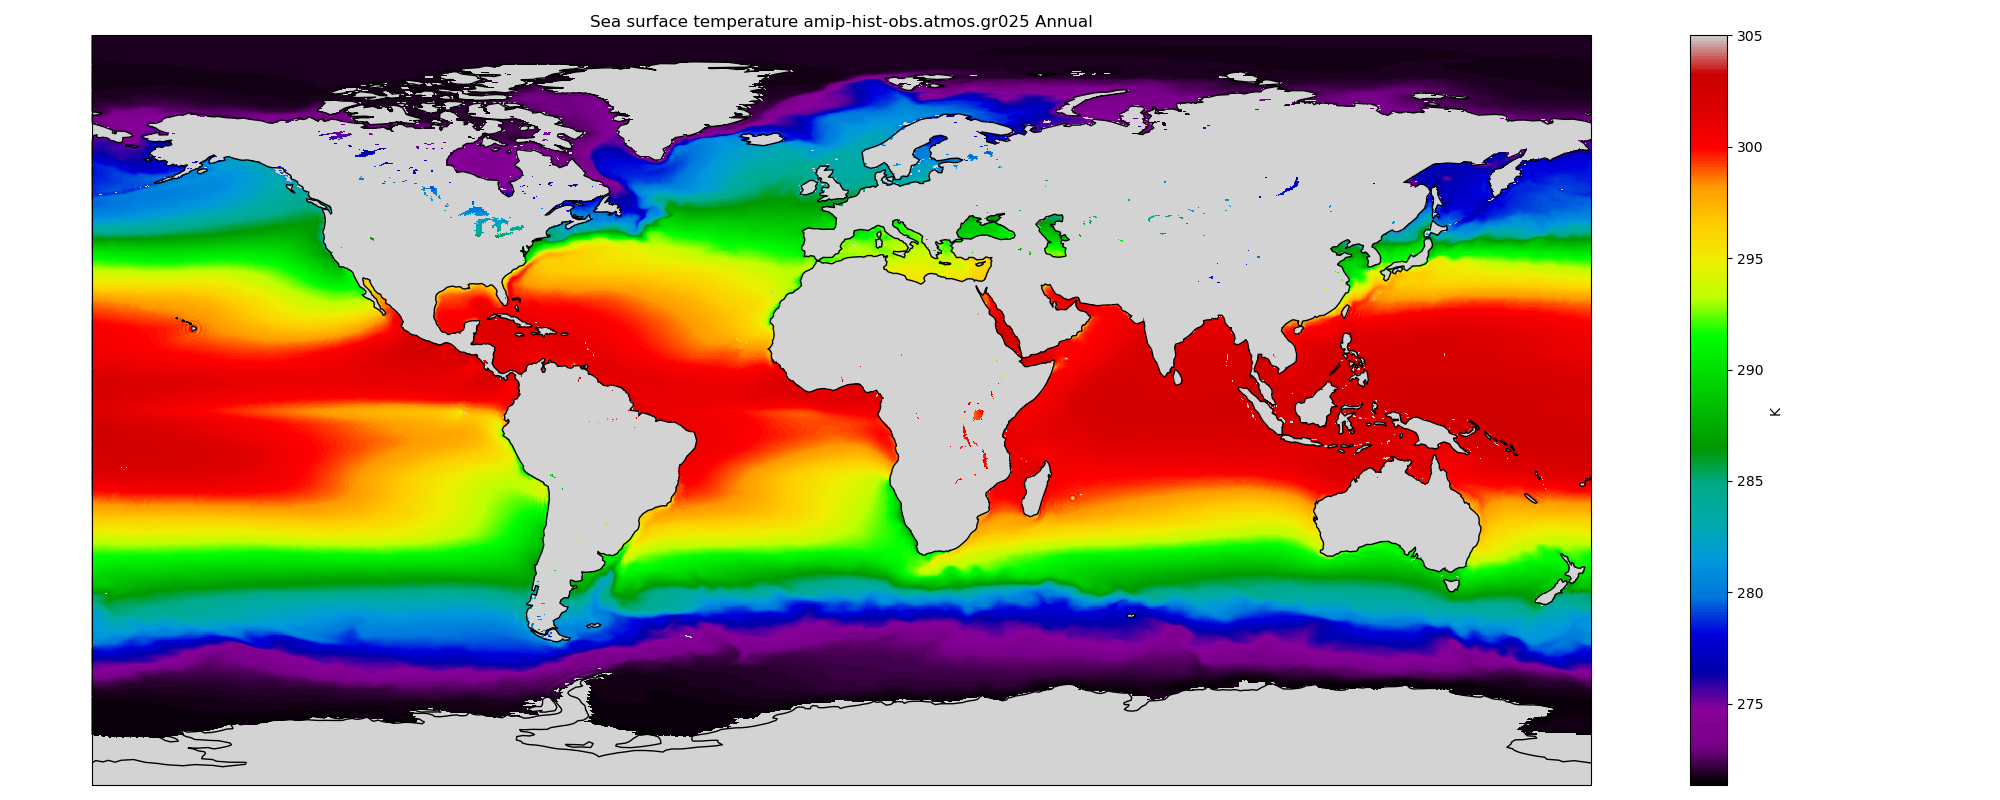

In [19]:
import panel as pn
pn.state.clear_caches()

pn.extension()
SIMULATIONS = ['amip-hist-obs.atmos.gr025',
 'amip-hist-obs-lr30.atmos.gr025',
 'amip-hist-obs-c-lr30-a-0.atmos.gr025',
 'amip-hist-obs-c-lr30-a-lr30.atmos.gr025']
VARIABLES = ['10si', '10u', '10v', '2d', '2t', 'cape', 'ci', 'cprate',
 'erate',
 'ewssra',
 'fal',
 'iews',
 'inss',
 'lcc',
 'lmlt',
 'mlsprt',
 'mn2t24',
 'mrort',
 'msdr',
 'msdsrf',
 'msdtrf',
 'msl',
 'mslhfl',
 'msnsrf',
 'msntrf',
 'msror',
 'msshfl',
 'mssror',
 'mtnsrf',
 'mtntrf',
 'mtsfr',
 'mx2t24',
 'nsssra',
 'sd',
 'skt',
 'soira',
 'sst',
 'stl1',
 'stl2',
 'stl3',
 'stl4',
 'swvl1',
 'swvl2',
 'swvl3',
 'swvl4',
 'tcc',
 'tciw',
 'tclw',
 'tcwv',
 'tprate']
# We define a widget to choose the simulation, 
simulation_w = pn.widgets.Select(name='simulation', options=SIMULATIONS, value="amip-hist-obs.atmos.gr025")
# Optionally choose another simulation to compare with
compare_with_w = pn.widgets.Select(name='compare_with', options=simulations + ["None", ], value="None")
# Choose the variable
variable_w = pn.widgets.Select(name="variable", options=VARIABLES, value="sst")
# Choose the season
season_w =  pn.widgets.Select(name="season", options=["Annual", "DJF", "MAM", "JJA", "SON"], value="Annual")
# Optionally choose a lat lon box to zoom in.
area_w = pn.widgets.ArrayInput(name="area [minlon, minlat, maxlon, maxlat]", value=None, max_array_size=4)
# Optionally choose the bounds for ther colorbar.
vmax_w = pn.widgets.FloatInput(name="vmax", value=None)
vmin_w = pn.widgets.FloatInput(name="vmin", value=None)
# Optionally choose a colormap
cmap_w = pn.widgets.Select(name="colormap", options=[
    'default', 'nipy_spectral', 'viridis', 'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
    'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
    'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn',
    'RdYlBu', 'RdYlGn', 'PiYG_r', 'PRGn_r', 'BrBG_r', 'PuOr_r', 'RdGy_r', 'RdBu_r'], value="default")

# Functions to load the data, results are cached. The monthly data is hardcoded here in get_variable.                                                
@pn.cache()
def get_dataset(simulation, subname):
    ds = ifs_to_latlon(ifs_fix_time_for_monthly_data(cat[simulation][subname].to_dask()))
    ds = ds.assign(**{"lon": np.mod(ds["lon"], 360)})
    return ds
                      
                    
@pn.cache()
def get_variable(variable, simulation, season, area):
    da = get_dataset(simulation, "2D_monthly_0.25deg")[variable]
    if season != "Annual":
        time_mask = da.time.dt.season == season
        da = da.sel(time=time_mask)
    if area is not None:
        if len(area) < 3:
            raise RuntimeError("Area needs to be an array with four elements.")
        da = da.sel(lon=slice(area[0], area[1]), lat=slice(area[2], area[3]))
    return da

# Main plotting function. If compare_with is not defined it will draw the mean field. If compare_with is define it will compute the 
# mean diffeence and the statistical significance. The non significant points are masked with light grey.
@pn.cache()
def plot_amip(variable, simulation, compare_with, season, area, cmap_name, vmin, vmax):
    if cmap_name != "default":
        cmap = plt.get_cmap(cmap_name).copy()
    else:
        cmap = plt.get_cmap("nipy_spectral").copy()
    cmap.set_bad("grey", alpha=0)
    fig = plt.figure(figsize=(20, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.background_patch.set_facecolor("lightgrey")
    ax.coastlines()
    da = get_variable(variable, simulation, season, area)
    plot_kwargs = dict(ax=ax)
    plot_kwargs["vmin"] = vmin
    plot_kwargs["vmax"] = vmax
    plot_kwargs["cbar_kwargs"] = dict(label=da.attrs["units"])
    
    if compare_with == "None":
        da.mean(dim="time").compute().plot(**plot_kwargs, cmap=cmap)
        plt.title(f"{da.attrs['name']} {simulation} {season}")
    else:
        da_to_compare = get_variable(variable, compare_with, season, area)
        diff = (da - da_to_compare).mean(dim="time").compute()
        
        ttest_pval = dttest_xr(da.chunk(dict(time=-1, lon=200, lat=200)), da_to_compare.chunk(dict(time=-1, lon=200, lat=200)))
        significance_mask = ttest_pval > 0.05
        diff = diff.where(~significance_mask)
        diff.plot(**plot_kwargs, cmap=cmap)
        plt.title(f"{da.attrs['name']} {simulation} - {compare_with} {season}")
    
    plt.tight_layout()
    return fig
# The following panel functions will define the location of the widgets and the main panel.
interactive_plot = pn.bind(plot_amip, variable_w, simulation_w, compare_with_w, season_w, area_w, cmap_w, vmin_w, vmax_w)

widgets = pn.GridBox(
    pn.WidgetBox(simulation_w, "Choose a IFS AMIP run."),  
    pn.WidgetBox(compare_with_w, "Choose another run to compare with."), 
    pn.WidgetBox(variable_w, "Choose a variable."),
    pn.WidgetBox(season_w, "Choose a season."),
    pn.WidgetBox(area_w, "Choose an area to zoom in (minlon, maxlon, minlat, maxlat"),
    pn.WidgetBox(cmap_w, "Choose a colormap."),
    pn.WidgetBox(vmin_w, "Colorbar lower bound."),
    pn.WidgetBox(vmax_w, "Colorbar upper bound."),
    ncols=4
)
main = pn.Pane(interactive_plot)
pn.Column(widgets, main).servable()

The next cell attemps to define another similar app that compares the variance of the simulations after removing their annual cycles.
It does however conflict with the previous ones. It is probably better to use different notebooks or to setup the apps in scripts (but then I don't now how to serve them from jupyterhub).

In [ ]:
pn.state.clear_caches()

def compute_mon_anom(da):
    return da.groupby("time.month").apply(lambda x: x - x.mean(dim="time"))

# @pn.cache()
def get_monanom_var(variable, simulation, season, area):
    da = get_variable(variable, simulation, season, area)
    da_monanom = compute_mon_anom(da)
    da_monanom_std = da_monanom.var(dim="time").compute()
    return da_monanom_std


def plot_amip_var(variable, simulation, compare_with, season, area, cmap_name, vmin, vmax):
    plt.ioff()
    if cmap_name != "default":
        cmap = plt.get_cmap(cmap_name)
    else:
        cmap = None
    fig = plt.figure(figsize=(20, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    da_monanom_var = get_monanom_var(variable, simulation, season, area)
    plot_kwargs = dict(ax=ax)
    plot_kwargs["vmin"] = vmin
    plot_kwargs["vmax"] = vmax
    
    
    if compare_with == "None":
        da_monanom_var.plot(**plot_kwargs, cmap=cmap)
        plt.title(f"{da_monanom_var.attrs['name']} {simulation} {season}")
        plot_kwargs["cbar_kwargs"] = dict(label=da_monanom_var.attrs["units"])
    else:
        da_to_compare_monanom_var = get_monanom_var(variable, compare_with, season, area)
        var_ratio = (da_to_compare_monanom_var / da_monanom_var) * 100
        plot_kwargs["cbar_kwargs"] = dict(label="%")
        var_ratio.plot(**plot_kwargs, cmap=cmap)
        # significance test?
        plt.title(f"{da_monanom_var.attrs['name']} {simulation} var / {compare_with} {season} var * 100")
    
    plt.tight_layout()
    return fig
    
monthly_anom_std = pn.bind(plot_amip_var, variable_w, simulation_w, compare_with_w, season_w, area_w, cmap_w, vmin_w, vmax_w)

widgets = pn.GridBox(
    pn.WidgetBox(simulation_w, "Choose a IFS AMIP run."),  
    pn.WidgetBox(compare_with_w, "Choose another run to compare with."), 
    pn.WidgetBox(variable_w, "Choose a variable."),
    pn.WidgetBox(season_w, "Choose a season."),
    pn.WidgetBox(area_w, "Choose an area to zoom in (minlon, maxlon, minlat, maxlat"),
    pn.WidgetBox(cmap_w, "Choose a colormap."),
    pn.WidgetBox(vmin_w, "Colorbar lower bound."),
    pn.WidgetBox(vmax_w, "Colorbar upper bound."),
    ncols=4
)
main = pn.Pane(monthly_anom_std)
pn.Column(widgets, main).servable()